### When using GG Colab

In [ ]:
# If using GG Colab, you need to upload file kaggle.json
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import kaggle
import os

In [ ]:
# Define the Kaggle dataset URL and download path
dataset_url = 'sayedmahmoud/alpaca-dataset'
download_path = './alpaca_dataset'

# Check if the dataset is already downloaded
if os.path.isdir(download_path) and any(os.scandir(download_path)):
    print(f'Dataset already exists in {download_path}')
else:
    print(f'Downloading dataset from Kaggle: {dataset_url}')
    kaggle.api.dataset_download_files(dataset_url, path=download_path, unzip=True)
    print(f'Dataset downloaded and extracted to {download_path}')

Dataset URL: https://www.kaggle.com/datasets/sayedmahmoud/alpaca-dataset
Dataset downloaded and extracted to ./alpaca_dataset


In [ ]:
train_path = './alpaca_dataset/dataset/train/'
test_path = './alpaca_dataset/dataset/test/'

BATCH_SIZE = 32
IMAGE_SIZE = (160, 160)  # without channels

# Load training dataset
train_dataset = keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle the train set
    label_mode='int'  # Use 'int' if you want integer labels, 'categorical' for one-hot encoding
)

# Load test dataset
test_dataset = keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle the test set
    label_mode='int'
)

Found 250 files belonging to 2 classes.
Found 77 files belonging to 2 classes.


In [ ]:
train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [ ]:
classes = train_dataset.class_names
classes

['alpaca', 'not_alpaca']

In [ ]:
for i, (images, labels) in enumerate(train_dataset.take(3)):  # Take 3 batches
    print(f'The {i}th Batch')
    print(labels)
    print('-'*10)

The 0th Batch
tf.Tensor([0 0 0 1 0 0 0 1 1 1 0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0], shape=(32,), dtype=int32)
----------
The 1th Batch
tf.Tensor([1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 0], shape=(32,), dtype=int32)
----------
The 2th Batch
tf.Tensor([1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 0], shape=(32,), dtype=int32)
----------


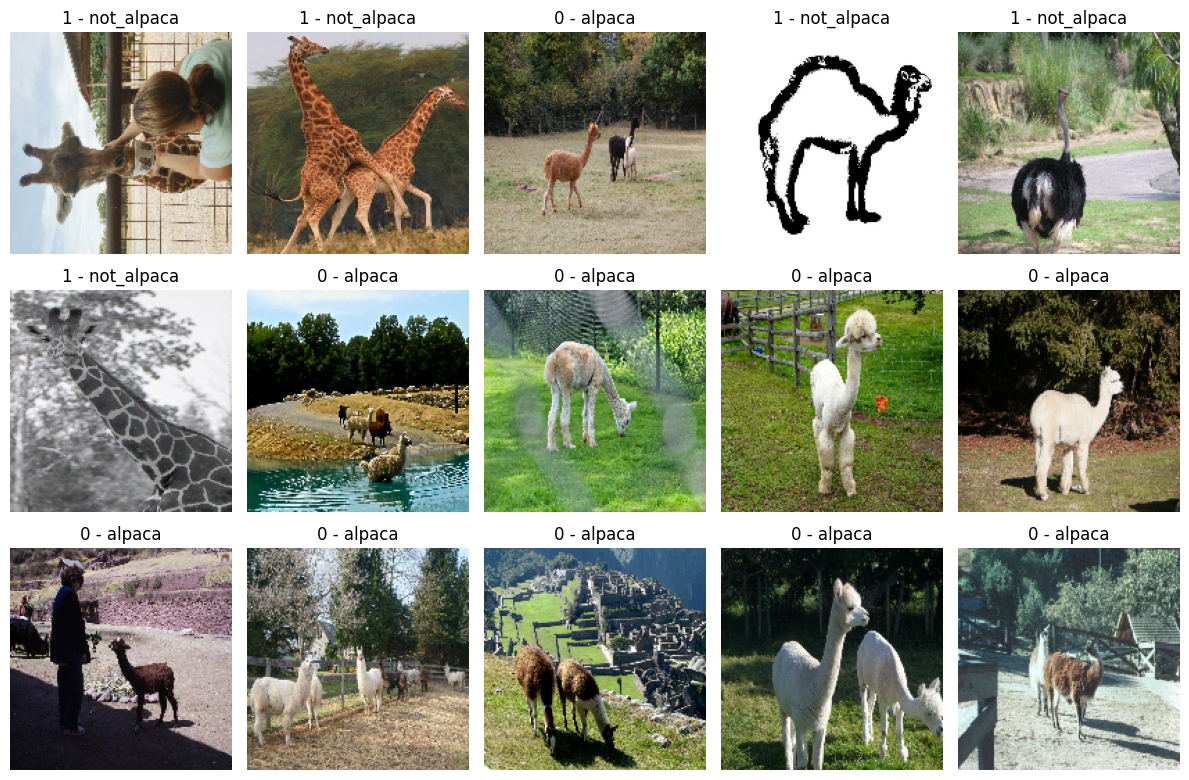

In [ ]:
# Define the number of rows and columns
n_rows = 3
n_cols = 5

plt.figure(figsize=(12, 8))
for images, labels in train_dataset.take(1):
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))  # uint8 is a data type used to represent integer values from 0 to 255.
        plt.title(f'{labels[i].numpy()} - {classes[labels[i].numpy()]}')
        plt.axis('off')

plt.tight_layout()
plt.show()

# Augment Data

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

You can set the number of elements to prefetch manually, or you can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later.  Ahh, so convenient!

As always, you're invited to read the official docs, which you can find for data augmentation [here](https://www.tensorflow.org/tutorials/images/data_augmentation).


In [ ]:
def augment_data():
    augmenter = keras.Sequential()
    augmenter.add(keras.layers.RandomFlip(mode='horizontal'))
    augmenter.add(keras.layers.RandomRotation(factor=0.25))  # 25% of 180 degrees
    augmenter.add(keras.layers.RandomZoom(height_factor=0.25, width_factor=0.25))
    augmenter.add(keras.layers.RandomContrast(factor=0.25))  # Adjust contrast by a factor between 0.75 and 1.25
    return augmenter

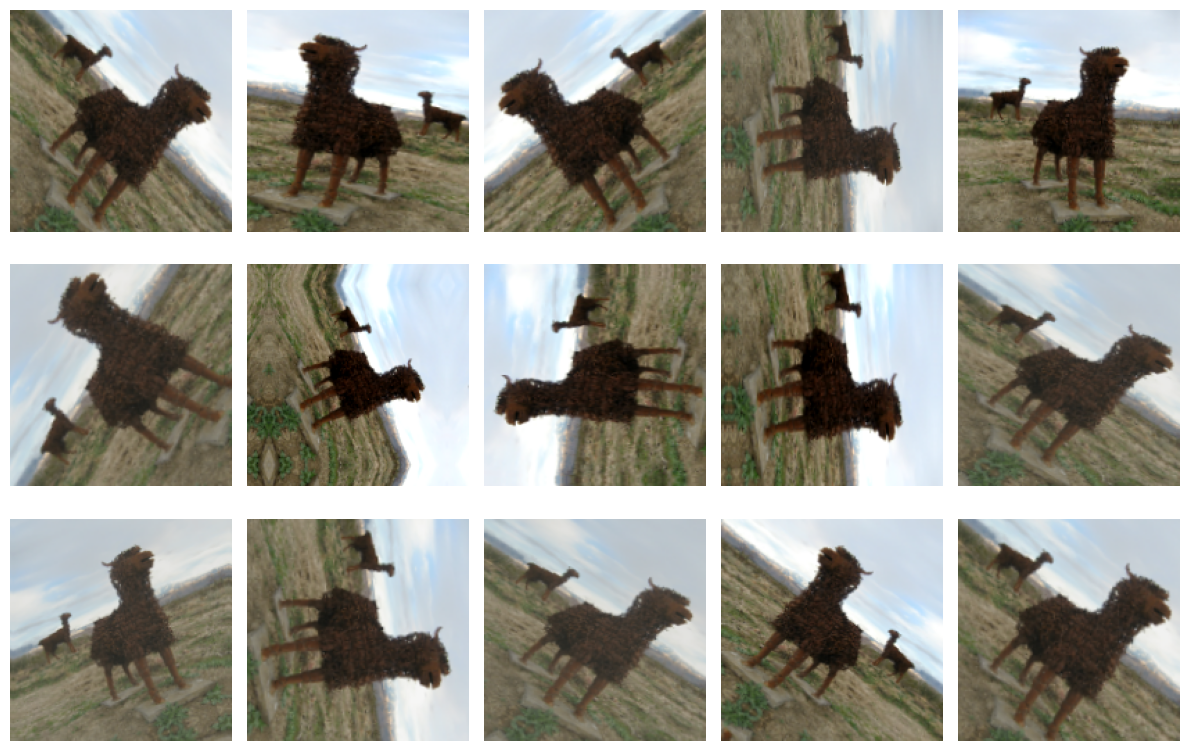

In [ ]:
# Define the number of rows and columns
n_rows = 3
n_cols = 5

plt.figure(figsize=(12, 8))
for images, _ in train_dataset.take(1):
    img = images[0]
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i+1)
        augmented_img = augment_data()(tf.expand_dims(img, axis=0))
        plt.imshow(augmented_img[0].numpy().astype('uint8'))  # uint8 is a data type used to represent integer values from 0 to 255.
        plt.axis('off')

plt.tight_layout()
plt.show()

# MobileNetV2

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep (just in case you felt the urge to plot the model yourself, prepare for a long journey!) and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics:

*   Depthwise separable convolutions
*   Thin input and output bottlenecks between layers
*   Shortcut connections between bottleneck layers

MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and  depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps:

1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution ==  **Shape of the depthwise convolution X Number of filters.**

<div style="text-align: center;">
    <img src="images/mobilenetv2.png" style="width:800px;height:500px;" alt="Identity Block Diagram">
</div>

Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information.

The shortcut connections, which are similar to the ones in traditional residual networks, serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers.

### View MobileNetV2 Architecture when Drop the Last Layers

In [ ]:
INPUT_SHAPE = IMAGE_SIZE + (3,)  # adding channels
INPUT_SHAPE

(160, 160, 3)

In [ ]:
mobileNetV2_with_lastLayer = keras.applications.MobileNetV2(input_shape=INPUT_SHAPE, include_top=True)
mobileNetV2_with_lastLayer.summary()

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
mobileNetV2_without_lastLayer = keras.applications.MobileNetV2(input_shape=INPUT_SHAPE, include_top=False)
mobileNetV2_without_lastLayer.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

### Now, It's time to Customize your own Model based on MobileNetV2

In [ ]:
def Custom_MobileNetV2(input_shape, augmenter_func):
    # Drop the last layer
    base_model = keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False
    )

    # Freeze the base model by making it non-trainable
    base_model.trainable = False

    # Create the input layer
    inputs = keras.Input(shape=input_shape)
    # Apply data augmentation to the inputs
    augmented_inputs = augmenter_func(inputs)
    # For MobileNetV2, call `mobilenet_v2.preprocess_input` on your inputs before passing them to the model.
    # It will scale input pixels between -1 and 1.
    scaled_inputs = keras.applications.mobilenet_v2.preprocess_input(augmented_inputs)

    # Set training to False to avoid keeping track of statistics in the batch norm layer
    output_of_baseModel = base_model(scaled_inputs, training=False)  # output is a conv layer

    # Global Average Pooling turns each channel into a scalar value. No need to flatten
    A0 = keras.layers.GlobalAveragePooling2D()(output_of_baseModel)
    # Include dropout with the probability of 0.2 to avoid overfitting
    dropOut = keras.layers.Dropout(0.2)(A0)
    # Classify binary
    outputs = keras.layers.Dense(units=1)(dropOut)

    # A complete model
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
model = Custom_MobileNetV2(
    input_shape=INPUT_SHAPE,
    augmenter_func=augment_data()
)

In [ ]:
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)          │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_15 (Sequential)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Training

### Train only the last few custom layers

In [ ]:
LR = 0.001

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
initial_epochs = 5
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=test_dataset)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 426ms/step - accuracy: 0.4651 - loss: 0.8370 - val_accuracy: 0.5844 - val_loss: 0.5421
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.6216 - loss: 0.6381 - val_accuracy: 0.5974 - val_loss: 0.4697
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.7325 - loss: 0.4968 - val_accuracy: 0.6104 - val_loss: 0.4648
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 362ms/step - accuracy: 0.7040 - loss: 0.4898 - val_accuracy: 0.6234 - val_loss: 0.4221
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - accuracy: 0.8285 - loss: 0.3811 - val_accuracy: 0.6623 - val_loss: 0.3853


In [ ]:
history.epoch

[0, 1, 2, 3, 4]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

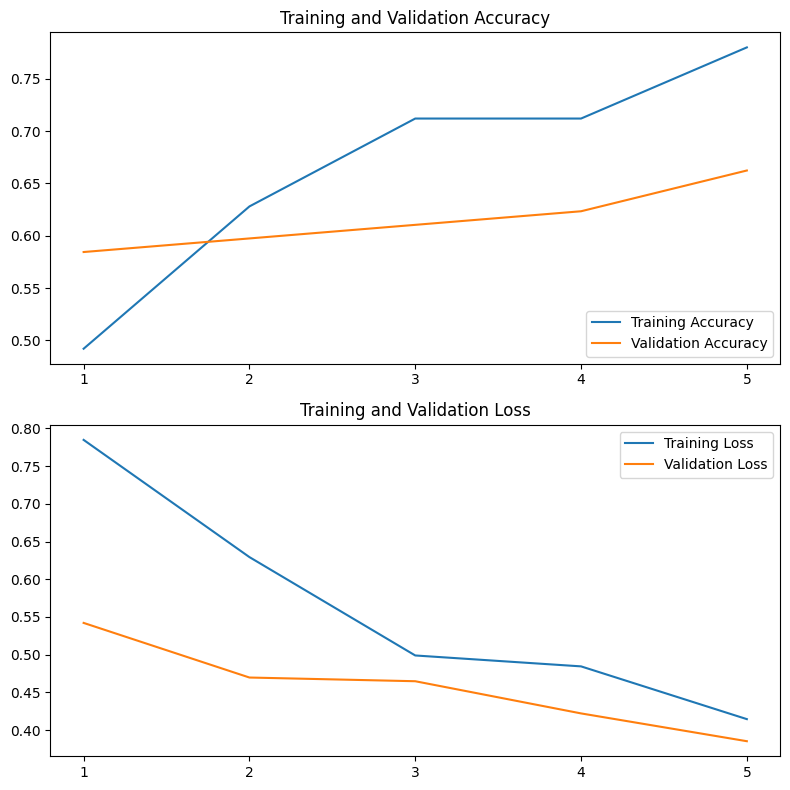

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.title('Training and Validation Accuracy')
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xticks(ticks=range(len(acc)), labels=range(1, len(acc)+1))

plt.subplot(2, 1, 2)
plt.title('Training and Validation Loss')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xticks(ticks=range(len(loss)), labels=range(1, len(loss)+1))

plt.tight_layout()
plt.show()

### Train some certain layers of MobileNetV2

You could try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. When you use a smaller learning rate, you take smaller steps to adapt it a little more closely to the new data. In transfer learning, the way you achieve this is by unfreezing the layers at the end of the network, and then re-training your model on the final layers with a very low learning rate. Adapting your learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

The intuition for what's happening: when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When you add new data, you generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to your data, such as soft fur or big teeth.

To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

Where the final layers actually begin is a bit arbitrary, so feel free to play around with this number a bit. The important takeaway is that the later layers are the part of your network that contain the fine details (pointy ears, hairy tails) that are more specific to your problem.

In [ ]:
model.layers

[<InputLayer name=input_layer_21, built=True>,
 <Sequential name=sequential_16, built=True>,
 <Functional name=mobilenetv2_1.00_160, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling2d_2, built=True>,
 <Dropout name=dropout_1, built=True>,
 <Dense name=dense_1, built=True>]

In [ ]:
base_model = model.layers[2]
base_model

<Functional name=mobilenetv2_1.00_160, built=True>

In [ ]:
def count_trainable_layers(model):
    total_layers = len(model.layers)
    trainable_layers = [layer for layer in model.layers if layer.trainable == True]
    n_trainable = len(trainable_layers)
    print(f'Total Layers = {total_layers}')
    print(f'Trainable Layers = {n_trainable}')
    return None

# No trainable layers because we freezed the entire base_model
count_trainable_layers(base_model)

# Freeze all the layers before the `train_at` layer
train_at = 120
for layer in base_model.layers[train_at: ]:
    layer.trainable = True

count_trainable_layers(base_model)

Total Layers = 154
Trainable Layers = 0
Total Layers = 154
Trainable Layers = 34


In [ ]:
"""
When you unfreeze layers (set them to be trainable), this changes the trainable status of the model,
and Keras needs to recompile to know which layers are now trainable and which ones are frozen.
"""

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR*0.1),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
fineTuning_epochs = 5
total_epochs =  initial_epochs + fineTuning_epochs

history_afterwards = model.fit(
    train_dataset,
    epochs=total_epochs,
    validation_data=test_dataset,
    initial_epoch = history.epoch[-1] + 1
)

Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 345ms/step - accuracy: 0.7498 - loss: 0.5815 - val_accuracy: 0.7273 - val_loss: 0.3473
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.8559 - loss: 0.3308 - val_accuracy: 0.8182 - val_loss: 0.2789
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.8758 - loss: 0.2847 - val_accuracy: 0.8442 - val_loss: 0.2554
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - accuracy: 0.8929 - loss: 0.2406 - val_accuracy: 0.8442 - val_loss: 0.2486
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - accuracy: 0.9156 - loss: 0.1978 - val_accuracy: 0.8571 - val_loss: 0.2357


In [ ]:
history_afterwards.epoch

[5, 6, 7, 8, 9]

In [ ]:
acc += history_afterwards.history['accuracy']
val_acc += history_afterwards.history['val_accuracy']

loss += history_afterwards.history['loss']
val_loss += history_afterwards.history['val_loss']

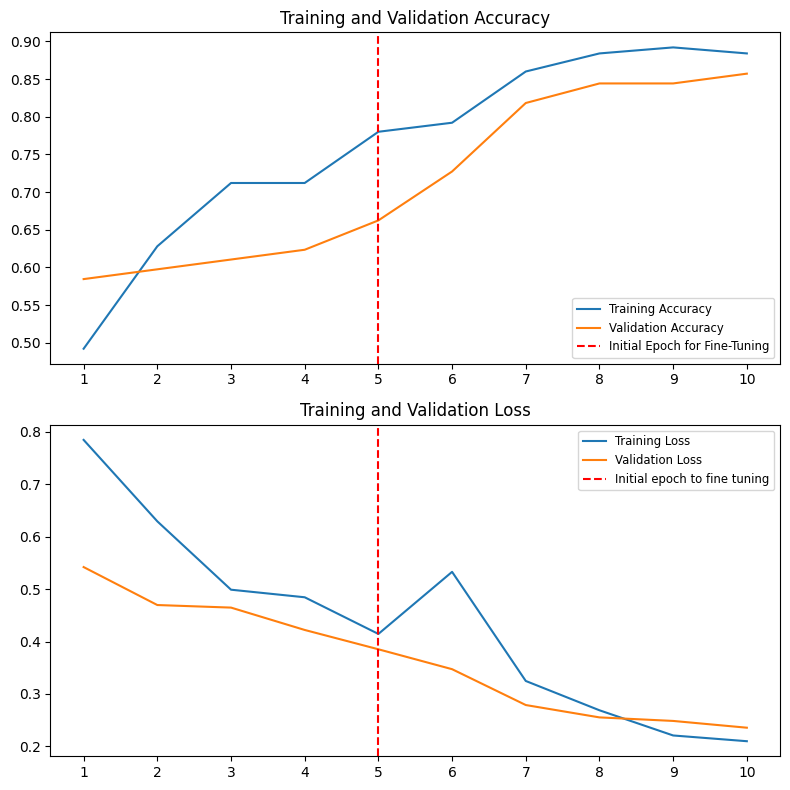

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.title('Training and Validation Accuracy')
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=history.epoch[-1],color='r', linestyle='--', label='Initial Epoch for Fine-Tuning')  # Add vertical line
plt.legend(loc='lower right', fontsize='small')
plt.xticks(ticks=range(len(acc)), labels=range(1, len(acc)+1))

plt.subplot(2, 1, 2)
plt.title('Training and Validation Loss')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=history.epoch[-1],color='r', linestyle='--', label='Initial epoch to fine tuning')  # Add vertical line
plt.legend(loc='upper right', fontsize='small')
plt.xticks(ticks=range(len(loss)), labels=range(1, len(loss)+1))

plt.tight_layout()
plt.show()